In [50]:
# 모듈과 라이브러리 임포트
# 데이터셋 불러오기
# 전체 센서 리스트 만들기

import numpy as np

from module_.dataLoader import dataLoader

episodes, transitions, labels = dataLoader('testbed')

sensors = set()
for e in episodes:
    sensors = sensors | set(e[:,0])
sensors = sorted(sensors)

tasks: ['Chatting', 'Discussion', 'GroupStudy', 'Presentation']


In [182]:
# 샘플 데이터셋에 대해서 시작시간 부터 종료시간까지 1초 단위로 Motion 센서의 ON과 OFF 상태를 Binary array로 변환함

i = 0
episode, transition, label = episodes[i], transitions[i], labels[i]

start_time, end_time = int(episode[0,2]), int(episode[-1,2])

active_log = np.zeros((end_time-start_time+1, len(sensors)))

active_states = {sensor: False for sensor in sensors}
active_startt = {sensor: 0 for sensor in sensors}

# test = []

for i in range(len(episode)):
    s, v, t = episode[i]
    t = int(t)-start_time
    if s[0]!="M": 
        # test.append(episode[i])
        continue

    if v=="true":
        if active_states[s]==False: # False -> True (State 변경)
            active_startt[s]=t
            active_states[s]=True

            # test.append(episode[i])
        else:                       # True -> True (이전 True까지 Update)
            active_log[active_startt[s]:t,sensors.index(s)]=1
            active_startt[s]=t
    else:
        if active_states[s]==True:  # True -> False (이전 True까지 Update하고 초기화)
            active_log[active_startt[s]:t,sensors.index(s)]=1
            active_startt[s]=t
            active_states[s]=False

            # test.append(episode[i])
    
    for sensor in sensors:
        if active_states[sensor] and t-active_startt[sensor]>40: # True -> ... (True 이후 이벤트가 없는 경우 - Update하고 초기화)
            active_log[active_startt[sensor]:active_startt[sensor]+40,sensors.index(sensor)]=1
            active_states[sensor]=False

            # test.append(
            #     np.array([sensor, "false", t+start_time])
            # )

    if i==len(episode)-1:
        for sensor in sensors:
            if active_states[sensor]:
                active_log[active_startt[sensor]:,sensors.index(sensor)]=1
                active_states[sensor]=False

                # test.append(
                #     np.array([sensor, "false", t+start_time])
                # )

Chatting82-Discussion35 2625.0 2639.0 43.75 43.983333333333334


In [ ]:
active_log.shape # (duration, sensor_number)

on_interval = {sensor: [] for sensor in sensors}

for i in range(active_log.shape[1]):

    # 1. 센서 i의 ON 구간을 전부 찾는다
    # 2. 각 구간에서 다른 센서들의 ON 비율을 계산해서 [0, 1] 정규화된 벡터를 저장한다 (시작, 종료, 벡터)
    # 최종 결과물 - 각 센서별 ON 상태에서의 벡터 집합
    # 각 센서별로 클러스터링을 합니다.

    col = active_log[:, i]
    start_on = 0
    on_ing = False
    for j in range(len(col)):
        if col[j]==1:
            if not on_ing:
                start_on = j
                on_ing = True
        else:
            if on_ing:
                on_interval[sensors[i]].append((start_on, j-1))
                on_ing = False
        
        if j==len(col)-1:
            if on_ing:
                on_interval[sensors[i]].append((start_on, j))
                on_ing = False


In [183]:
# Time windows

l, r = int(episode[transition-1,2])-start_time, int(episode[transition,2])-start_time

time_interval = 60

time_windows = []
ground_truth = set()
for i in range(0, len(active_log), time_interval):
    if i<=l<i+time_interval:
        ground_truth.add(int(i/time_interval))
    if i<=r<i+time_interval:
        ground_truth.add(int(i/time_interval))

    window = np.sum(active_log[i:i+time_interval,:], axis=0)
    time_windows.append(window)

ground_truth = list(ground_truth)
time_windows = np.array(
    time_windows
) #/ time_interval

print(ground_truth)

[43]


In [49]:
print(label, ground_truth)
# left = time_windows[:ground_truth[-1]]
# right = time_windows[ground_truth[-1]:]

# np.savetxt(f'./csv/{label.split("-")[0]}.csv', left, delimiter=",")
# np.savetxt(f'./csv/{label.split("-")[1]}.csv', right, delimiter=",")

full = time_windows
np.savetxt(f'./csv/{label}.csv', full, delimiter=",")

Presentation81-GroupStudy12 [36, 37]


In [184]:
# Calculate correlation

from itertools import combinations

l = []
past_length = 3
long_term_correlation = []

# score = []

for i in range(len(time_windows)):

    # Previous {past_length} time windows' average relationship
    prev_avg_correlation = np.mean(
        np.array(long_term_correlation), axis=0
    )

    curr_correlation = np.zeros((len(sensors), len(sensors)))

    window = time_windows[i]
    # active_sensors = [j for j in range(len(window)) if window[j]!=0.]
    active_sensors = [j for j in range(len(window))]

    # pair = list(combinations(active_sensors, 2))
    pair = list(combinations(active_sensors, 2)) + [(si, si) for si in range(len(sensors))]

    for a, b in pair:
        r, c = max(a, b), min(a, b)
        weight = window[a]*window[b]/(time_interval**2)
        curr_correlation[r, c] = weight

    l.append(curr_correlation.copy())

    curr_avg_correlation = np.mean(
        np.array(long_term_correlation[1:]+[curr_correlation]), axis=0
    )

    # Decision
    if i==0:
        print("Initialization: No previous relationship")
        # score.append(0.)
    else:
        # prev_avg_correlation - 이전 N개의 Relationship 평균
        # curr_avg_correlation - 현재 포함 N개의 Relationship 평균

        difference = abs(prev_avg_correlation-curr_avg_correlation)

        # score.append(np.mean(difference))

    long_term_correlation.append(curr_correlation.copy())
    long_term_correlation = long_term_correlation[-past_length:]



Initialization: No previous relationship


/home/kisoo/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kisoo/.local/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [187]:
# Apply correlation

scores = []

win_num = 3

for i in range(len(time_windows)):
    window = time_windows[i]
    # active_sensors = [j for j in range(len(window)) if window[j]>0.]
    # active_sensors = [j for j in range(len(window))]

    # pair = list(combinations(active_sensors, 2))
    pair = list(combinations([si for si in range(len(sensors))], 2)) + [(si, si) for si in range(len(sensors))]

    prev_coefficients = l[max(0, i-win_num):i]
    curr_coefficient = l[i]
    score = 0.

    if len(prev_coefficients)==0:
        scores.append(0)
        continue

    for a, b in pair:
        r, c = max(a, b), min(a, b)
        prev_c = sum([item[r, c] for item in prev_coefficients])/len(prev_coefficients)
        # weight = window[a]*window[b]/(time_interval**2)
        # weight = abs(window[a]+window[b])/(2*time_interval)
        curr_c = curr_coefficient[r, c]

        score += abs(prev_c-curr_c)
        # score += weight*(1-prev_c)
    
    scores.append(score)

## time windows to csv file

In [ ]:
import pandas as pd

df = pd.DataFrame(time_windows)
df.columns = sensors
df.index = [i*60 if i not in ground_truth else "transition" for i in range(1, len(time_windows)+1)]
df.to_csv(f"./csv/{label}.csv", sep=",")

[3.344444444444444, 10.965648148148148, 8.421296296296298, 7.151574074074075]
75


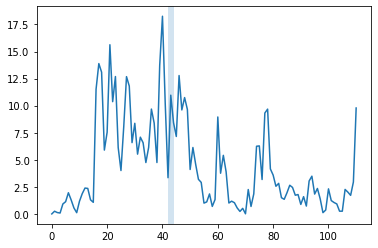

In [188]:
from matplotlib import pyplot as plt

plt.plot(range(len(scores)), scores)
min_ = min(ground_truth)
max_ = max(ground_truth)

plt.axvspan(min_-1, max_+1, alpha=0.2)
print(scores[min_-1:max_+3])
print(len([score for score in scores if score>1.5]))

In [ ]:
# RuLSIF            
from module_.featureExtraction import feature_extraction
from module_.changePointDetection import change_point_detection
from matplotlib import pyplot as plt

# test = np.array(test)

# features = np.array(
#     feature_extraction(test, 'testbed', sensors)
# )
# scores = np.array(
#     change_point_detection(features, 'RuLSIF')
# )
# score_s = np.array(change_point_detection(time_windows, "RuLSIF"))

fig = plt.figure(figsize=(20, 1))
ax = fig.add_subplot(1, 1, 1)

plt.title(label)
# plt.ylim(0, 1)
plt.plot(range(len(score)), score)
for item in ground_truth:
    plt.axvline(x=item, color="g", linestyle=":")
# plt.axhline(y=0.1, color="r", linestyle=":")